# 0. Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from matplotlib import patches
import matplotlib.pyplot as plt

# 1. Data

First, we should import the necessary libraries and the data-set. To make the data-set ready for the calculations, only the variables “Ozone” and “Temp” should be selected. Plus, not to face any error NA values should be dropped if there is any. Also, I prefer to use the NumPy array instead of using pandas data frame. That’s why I converted it to a NumPy array.

In [2]:
df= pd.read_csv(
    'data/airquality.csv', 
    sep=",", 
    decimal='.'
)
df.head()

,Unnamed: 0,Ozone,Solar.R,Wind,Temp,Month,Day
0,1,41.0,190.0,7.4,67,5,1
1,2,36.0,118.0,8.0,72,5,2
2,3,12.0,149.0,12.6,74,5,3
3,4,18.0,313.0,11.5,62,5,4
4,5,NaN,NaN,14.3,56,5,5


In [3]:
df = df[['Ozone', 'Temp']]
df = df.dropna()
df = df.to_numpy()

In [4]:
df.shape

(116, 2)

# 2. Calculation of MD

For the second step, we need to obtain the necessary values to calculate the distance between center and point. So, these are the center point and covariance matrix between the “Ozone” and “Temp” variables.

In [5]:
# Covariance matrix
covariance = np.cov(df, rowvar=False)

In [6]:
covariance

array([[1088.20052474,  218.52121439],
       [ 218.52121439,   89.97443778]])

In [7]:
# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

In [8]:
covariance_pm1

array([[ 0.00179379, -0.0043566 ],
       [-0.0043566 ,  0.02169515]])

In [9]:
# Center point
centerpoint = np.mean(df, axis=0)

In [10]:
centerpoint

array([42.12931034, 77.87068966])

For the third step, we are ready to find the distance between the center point and each observation (point) in the data-set. We also need to find a cutoff value from the Chi-Square distribution. **The reason why Chi-Square is used to find cutoff value is, Mahalanobis Distance returns the distance as squared (D² ).** We should also take the quantile value as 0.95 while finding cutoff because the points outside the 0.95 (two-tailed) will be considered as an outlier. Less quantile means less cutoff value. We also need a degree of freedom value for Chi-Square, and it is equal to the number of variables in our data-set, so 2.

In [11]:
# Distances between center point and 
distances = []
for i, val in enumerate(df):
    p1 = val
    p2 = centerpoint
    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
    distances.append(distance)
distances = np.array(distances)

In [12]:
distances

array([2.45907773e+00, 5.01584040e-01, 9.37261736e-01, 3.17223080e+00,
       1.95382558e+00, 2.10505386e+00, 4.88231046e+00, 3.24738122e+00,
       1.35393435e+00, 9.12282292e-01, 1.57562818e+00, 1.11385684e+00,
       5.43291539e+00, 2.19376336e+00, 2.33485072e+00, 5.22145783e+00,
       1.33448880e+00, 2.89809874e+00, 3.99748191e+00, 9.31830944e-01,
       3.17785963e+00, 4.86994100e+00, 1.40826315e+00, 1.48960908e-01,
       8.83592614e+00, 3.95100540e-02, 1.15152620e+00, 1.63575275e+00,
       2.07465514e+00, 1.71459512e+00, 6.56985609e-01, 5.32540825e-01,
       1.99064802e+00, 8.64384792e-01, 1.12318836e+00, 1.13266328e+01,
       7.60578501e-01, 6.72688743e-01, 4.51356803e-01, 6.74093035e-01,
       1.32953844e+00, 2.97670069e+00, 2.97670069e+00, 1.82675458e+00,
       1.00286469e+00, 1.03556407e+00, 2.96378788e+00, 1.14202794e-01,
       7.17610507e-01, 4.46023244e-01, 1.31384263e+00, 5.87584707e-01,
       6.68500262e-01, 1.32391418e+00, 4.79405873e+00, 2.04456205e+00,
      

In [13]:
# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.95, df.shape[1])  # df.shape[1] = 2 <-- degree of freedom

In [14]:
cutoff

5.991464547107979

In [15]:
# Index of outliers
outlierIndexes = np.where(distances > cutoff )

In [16]:
outlierIndexes

(array([24, 35, 67, 81], dtype=int64),)

In [17]:
# To check the distances
distances[outlierIndexes]

array([ 8.83592614, 11.32663284,  6.38519353, 25.20029124])

In [18]:
print('--- Observations found as outlier -----')
print(df[distances > cutoff, :])

--- Observations found as outlier -----
[[115.  79.]
 [135.  84.]
 [122.  89.]
 [168.  81.]]


# 3. Plot of MD

Finally, we have four outliers at the index of [24, 35, 67, 81]. Now, let’s make and plot to understand this process more clearly.

In [19]:
## Finding ellipse dimensions 
pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
lambda_, v = np.linalg.eig(covariance)  # lambda_ = eigenvalue, v = normalized eigenvector
lambda_ = np.sqrt(lambda_)

In [20]:
ell_radius_x

1.3032115492700838

In [21]:
ell_radius_y

0.5492173138649837

In [22]:
lambda_

array([33.67404037,  6.65086217])

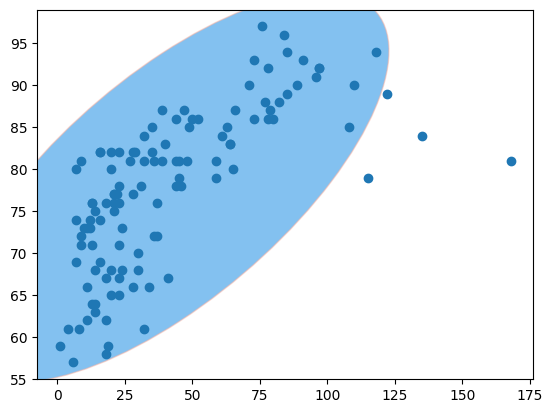

In [23]:
# Ellipse patch
ellipse = patches.Ellipse(
    xy=(centerpoint[0], centerpoint[1]),
    width=lambda_[0]*np.sqrt(cutoff)*2, 
    height=lambda_[1]*np.sqrt(cutoff)*2,
    angle=np.rad2deg(np.arccos(v[0, 0])), 
    edgecolor='#fab1a0'
)
ellipse.set_facecolor('#0984e3')
ellipse.set_alpha(0.5)
fig = plt.figure()
ax = plt.subplot()
ax.add_artist(ellipse)
plt.scatter(df[:, 0], df[:, 1])
plt.show()